## 3D-Printing using Turtle Graphics
- A "Turtle Graphics" approach is used to define the extrusion paths:  A series of `(segment length, change of heading angle)` - tuples defines a path segment. e.g. the tuple `(2*pi ,2*pi)` defines a unit circle, the tuple `(1,0)` a straight line of unit length, and `(0,-30*deg)` turns on the spot `30deg` to the right.
- Complex numbers are used for the 2D coordinates:  2D translations and rotations are simple additions and multiplications of complex numbers. E.g. the complex expression `(3+5j)*1j**(30/90)` rotates the point `(x=3,y=5)` counter-clockwise by `30deg` around the origin.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLengthArea(Segs):
  nSegs=len(Segs)
  dl,dang,*opts=np.array(Segs).transpose()
  l=sum(dl)
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return l,area

def InterpSegments(Segs,t,p0=0.+0.j,a0=0+1j,scale=1.0,return_headings=False,return_props=False,eps=1e-6):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array(Segs).transpose()
  l,ang_,*opt=np.cumsum([(0,0)]+Segs,axis=0).transpose()
  ang=exp(1j*ang_)
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(np.insert(viSeg,0,0+0j))
  if not hasattr(t,'__getitem__'): #not an array
    t=np.array([t]) #convert to array
  else:
    if t.shape==(): #no dimensions
      t=np.array([t])
    else:
      t=np.array(t) 
  T=t.astype(int)
  if ((abs(pSeg[-1])<eps) and (abs(ang[-1]-(1+0j))<eps)):
    pr,ar=np.zeros((len(t),),dtype=complex), np.ones((len(t),),dtype=complex) # closed loop. No translation/rotation necessary for t>1
  else: #endpoint of path != startpoint => repeat path for t>1 by translating and rotating it
    def rotateSecant(v,beta,T):
      beta2=beta/2
      rot2=exp(1j*beta2)
      uniqueT,inverseIndex=np.unique(T,return_inverse=True) #don't re-calculate for identical values of T
      p=(v*rot2**(uniqueT-1)/np.sinc(beta2/np.pi) * uniqueT * np.sinc(uniqueT*beta2/np.pi))[inverseIndex]
      a=(rot2**(2*uniqueT))[inverseIndex]
      return p,a
    pr,ar=rotateSecant(pSeg[-1],ang_[-1],T)
  pr+=p0
  ar*=a0
  l=l/l[-1]
  Xx=np.interp(np.array(t)%1,l,range(len(l)))
  X=Xx.astype(int) #segment index
  x=Xx%1 #within seggment
  p=pSeg[X] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  p=p*ar+pr
  if len(p)==1:
      p=p[0] #convert array to single value if argument was a single value
  result=[p]
  if return_headings:
    a=ang[X]*np.exp(1j*dang[X]*x)*ar
    result.append(a)
  if return_props:
    result.append(*opts)
  return result[0] if len(result)==1 else result

def Segments2Complex(Segs,p0=0.+0.j,scale=1.0,a0=0+1j,tol=0.05,offs=0,loops=1,return_heading=False,return_start=False,return_props=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0
  p=p0
  p-=1j*a*offs
  if return_start:
      result=[p]
      if return_heading:
        result.append(a)
      if return_props:
        result.append(*Segs[-1][2:])
      yield result[0] if len(result)==1 else result
  for _ in range(loops):
      for l,da,*opts in Segs:
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for _ in range(n):
          p+=v
          result=[p]
          if return_heading:
            result.append(a)
          if return_props:
            result.append(*opts)
          yield result[0] if len(result)==1 else result
          v*=dda
          a*=dda

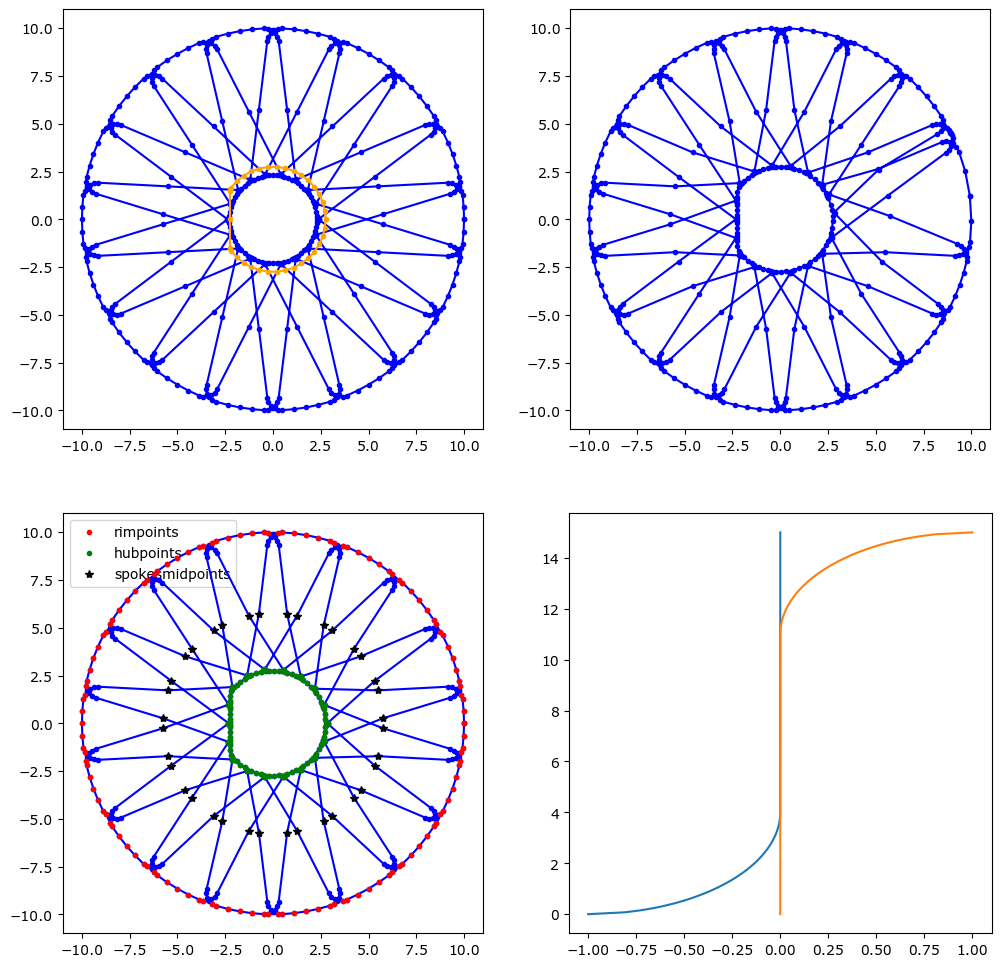

In [2]:
from math import pi,cos
deg=pi/180
def phase_advance(phi,phi_start,phi_end,max_advance):
    return np.exp(((phi>phi_start) & (phi<phi_end))*1j*max_advance*(0.5-0.5*np.cos((phi-phi_start)/(phi_end-phi_start)*2*pi)))
def getMeshSeg(mesh,j):
    return mesh[abs((j+len(mesh)//2)%len(mesh)-len(mesh)//2)]
def mirror(a): return a+a[::-1]
def offset(path,dr): return [(l+dr*a,a)for l,a in path]
def meshSegment(l=1,nl=1,w1=0.5,w2=0.5,r1=0.1,r2=0.1,a=60*deg,c=0*deg,da=0,daw=0):
    return mirror([(w1/2,daw/2,dict(EW=1,c='r',part='rim')),
                   (r1*a,a+da/4-daw/2-c/4,dict(EW=0.85,c='b',part='rim')),
                   *((l/nl,c/2,dict(EW=0.85*(1-i/(nl-1))+0.5*(i/(nl-1)),c='orange',part='spoke')) for i in range(nl)),
                   (r2*a,-a+da/4-daw/2-c/4,dict(EW=0.5,c='g',part='hub')),
                   (w2/2,daw/2,dict(EW=0.5,c='g',part='hub'))])
hex=mirror([(0.5,0),(0.1,30*deg)])*6
ns,nc=18,5    
capstanSegments=meshSegment(l=8,nl=2,w1=2.8,w2=0.5,r1=1,r2=0.2,a=68* deg,da=2*pi/(ns/nc),c=0*deg,daw=0.7* 2*pi/ns)

pr1,props=list(zip(*Segments2Complex(capstanSegments,scale=1,tol=0.01,loops=ns,return_start=True,return_props=True)))
pr1=np.array(pr1)
pr1max=max(pr1.real)
pr1min=min(pr1.real)
pr1=pr1/(max(pr1.real)-min(pr1.real))*20
pr1max=max(pr1.real)
pr1min=min(pr1.real)
pr1_r=(pr1max-pr1min)/2
pr1+=pr1_r
pr1_ri=np.min(abs(pr1))
t=((np.log(pr1).imag)/(2*pi))%1#phase angle [0..1[
amp=abs(pr1)#amplitude
ampmax=max(amp)
ampmin=min(amp)
ampmid=(max(amp)+min(amp))/2

thread=mirror([(0.1,60*deg),(1,0),(0.14,-60*deg)])
pthread=np.array(list(Segments2Complex(thread,return_start=True,tol=0.001)))
pthread/=pthread[-1].imag
Dflatcp=-(2.5-0.5)+1j*(2.5**2-2**2)**0.5 #corner point of D-shaft 5mm diameter
Dflatang=np.log(Dflatcp).imag
Dshaft=mirror([(2.5*Dflatang,Dflatang),(0,pi-Dflatang),(Dflatcp.imag,0)])
EW=0.5
pDshaft=np.array(list(Segments2Complex(offset(Dshaft,EW/2),p0=2.5+EW/2,return_start=True,tol=0.01)))
vDshaft=InterpSegments(offset(Dshaft,EW/2),t,p0=2.5+EW/2)
vDshaft=vDshaft*  amp/pr1_ri#offset points to account for extrusion width
vDshaftmix=pr1.copy()
rimpoints=(np.arange(len(pr1))[abs(amp-pr1_r)<0.1])
hubpoints=(np.arange(len(pr1))[amp<(0.75*pr1_ri+0.25*pr1_r)]) 
spokesmidpoints=np.arange(len(pr1))[np.abs(amp-ampmid)/pr1_r<0.1]
vDshaftmix[hubpoints]=vDshaft[hubpoints]
t=np.linspace(0,2*pi,301)
r=8
pc=r*np.exp(1j*t)
pt=pc*(r+np.interp(t/(2*pi),pthread.imag,pthread.real))/r
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(12,12))
#ax4.plot(vhexmix.real,vhexmix.imag,'b.-')
ax1.plot(pDshaft.real,pDshaft.imag,'.-',c='orange',zorder=6)
ax3.plot(vDshaftmix.real,vDshaftmix.imag,'b.-',zorder=6)
ax3.plot(vDshaftmix[rimpoints].real,vDshaftmix[rimpoints].imag,'r.',zorder=7,label='rimpoints')
ax3.plot(vDshaftmix[hubpoints].real,vDshaftmix[hubpoints].imag,'g.',zorder=8,label='hubpoints')
ax3.plot(vDshaftmix[spokesmidpoints].real,vDshaftmix[spokesmidpoints].imag,'*',c='k',zorder=9,label='spokesmidpoints')
#ax2.plot(vhex.real,vhex.imag,'b.-',zorder=5)
ax1.plot(pr1.real,pr1.imag,'b.-')
#ax1.scatter(pr1.real,pr1.imag,c=[prop['c'] for prop in props])
#ax1.plot(phex.real,phex.imag,'r.-',zorder=4)
for phi_start,phi_end,max_advance in [((0.5-1)*2*pi/ns,(0.5+1)*2*pi/ns,0.7*2*pi/ns)]:
  vDshaftmix_=phase_advance(np.log(vDshaftmix).imag,phi_start,phi_end,max_advance)*vDshaftmix
  ax2.plot(vDshaftmix_.real,vDshaftmix_.imag,'b.-',zorder=6)
zt=15.0
zb=0
zr=np.linspace(0.0,zt,200)
r_lead_in=4.0
phase_advance_bottom=[-(1.0-(r_lead_in**2-min(max(r_lead_in-(z-zb),0.0),r_lead_in)**2)**0.5/r_lead_in) for z in zr] 
ax4.plot(phase_advance_bottom,zr)
phase_advance_top=[(1.0-(r_lead_in**2-min(max(r_lead_in-(zt-z),0.0),r_lead_in)**2)**0.5/r_lead_in) for z in zr] 
ax4.plot(phase_advance_top,zr)
for ax in(ax1,ax2,ax3):
  ax.set_aspect('equal')
#  ax.set_xlim(-12.5,12.5)
#  ax.set_ylim(-12.5,12.5)
ax3.legend(loc='upper left')
plt.show()

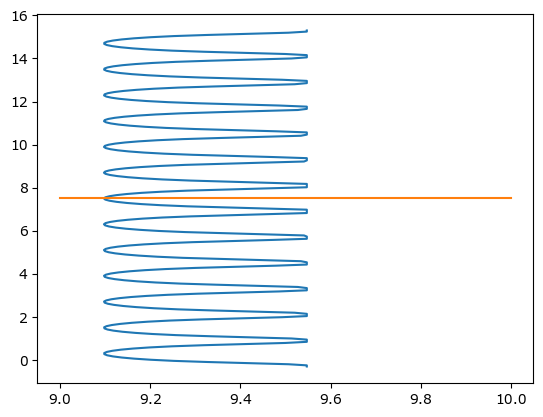

In [3]:
from matplotlib import pyplot as plt
import numpy as np
def thread_depth_pattern(z,phi,pitch=1.2,d_wire=0.9,l_circ=60,tang_ang=30*deg,z0=0.0):
    r_circ=(l_circ**2-pitch**2)**0.5/(2*np.pi)
    r_wire=d_wire/2
    z_=abs((z-z0-phi/(2*pi)*pitch+pitch/2)%pitch-pitch/2)
    flank=z_>r_wire*np.cos(tang_ang)
    result=r_circ
    if flank:
      result+=min(0,z_/np.tan(tang_ang)-r_wire/np.sin(tang_ang))
    else:
      result-=(r_wire**2 - z_**2)**0.5
    return result

zb=0.0
zt=15.0
pitch=1.2
zmid=(zt+zb)/2
n=((zt-zb)+pitch/2)//pitch
z=np.linspace(zmid-n/2*pitch,zmid+n/2*pitch,301 )
plt.plot([thread_depth_pattern(zi,0,z0=zmid) for zi in z],z)
plt.plot((9,10),(zmid,zmid))

In [4]:
 if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print(e)
    print('Attempting to install missing packages. Please wait ...')
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files
import fullcontrol as fc
from math import cos, tau

In [5]:
steps=[]
nominal_EW=0.75    # extrusion width
nominal_print_speed=10*60 #print slow to give the layer time to cool
print_speed=nominal_print_speed
hl=0.2
FilamentDiameter=1.75
tol=0.03
nwipe=5
nskip=5
jt=0
nskirt=0
skirtoffs=1.5
ehmin=hl/4
chamfer=0.75

path=pr1[1:]

EWs=[prop['EW'] for prop in props[1:]]
part=[prop['part'] for prop in props[1:]]
r=max(path.real)
rskirt=r+skirtoffs
p=-1j*rskirt
steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=hl)))
steps.append(fc.Extruder(on=True))
n=200
dang=1j**(4/n)
for i in range(n):
  p*=dang
  steps.append(fc.Point(x=p.real,y=p.imag))
steps.append(fc.Extruder(on=False))
n=len(path)

#capstan dimensions
zb=0
zt=zb+15
l_circ=60 #circumference of the capstan (wire length per turn)
pitch=1.2
d_wire=0.9 #=shape of the groove
tang_ang=30*deg

zmid=(zt+zb)/2

dzdj=hl/n

#print(w)
dwdj=0
old_eh=-1
old_ew=-1
jt=0
p=path[-1]
z=zb+ehmin
dmeshangdz=-pi/2/(zt-zb) #altogether 1/2 turn (negative, so that thread can be positive
old_p=None  
while  z<(zt+hl):
  jt=(jt+1)%n
  z+=dzdj
  eh=min(z-zb if z<(zb+hl+ehmin) else hl ,zt-(z-hl))
  p=path[jt]
  mesh_ang=dmeshangdz*z
  p*=np.exp(1j*mesh_ang)#twist the mesh
  t=((np.log(p).imag)/(2*pi))%1#phase angle [0..1[
  amp=abs(p)#amplitude
  if (amp/pr1_ri*2.5) <5:# near hub
      amp=amp/pr1_ri*2.5
      amp=max(amp,2.5+chamfer-(zt-z),2.5+chamfer-(z-zb))
      p=InterpSegments(offset(Dshaft,EW/2),t,p0=2.5+EW/2)*amp/2.5 #Dshaft
  p=p/amp*min(amp,pr1_r-chamfer+(zt-z),pr1_r-chamfer+(z-zb))
  if amp>0.6*pr1_r:
    r_lead_in=4
    max_phase_advance=0.7*2*pi/ns
    #bottom lead-in:
    phase_advance_z=(1.0-(r_lead_in**2-min(max(r_lead_in-(z-zb),0.0),r_lead_in)**2)**0.5/r_lead_in)*max_phase_advance
    p*=phase_advance(np.log(p).imag,
                  phi_start=(0.5-1 )*2*pi/ns+mesh_ang, phi_end=(0.5+1)*2*pi/ns+mesh_ang,
                  max_advance=phase_advance_z)
    #top lead-out:
    phase_advance_z=-(1.0-(r_lead_in**2-min(max(r_lead_in-(zt-z),0.0),r_lead_in)**2)**0.5/r_lead_in)*max_phase_advance
    p*=phase_advance(np.log(p).imag,
                  phi_start=(0.5-1-1)*2*pi/ns+mesh_ang, phi_end=(0.5+1-1)*2*pi/ns+mesh_ang,
                  max_advance=phase_advance_z)
    
    thread_amp=thread_depth_pattern(z,phi=np.angle(p),pitch=pitch,d_wire=d_wire,l_circ=l_circ,tang_ang=tang_ang,z0=zmid+pitch/2)
    p_amp=abs(p)
    chamfer_amp=pr1_r+2*chamfer - min(z-zb,zt-z) #inside chamfer
    p=p/pr1_r*min(p_amp,max(thread_amp,chamfer_amp)) #don't stretch surface outward
  ew=EWs[jt]
  if (abs(eh-old_eh)/hl)>0.01 or abs(ew-old_ew)>0.005:
   # print(f'{zb=}{z=}{zt=}{eh=}{w=}')
    steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=eh,width=ew))
    steps.append(fc.Printer(print_speed=nominal_print_speed*nominal_EW/ew))#set print speed to keep extrusion rate constant
    old_eh=eh
    old_ew=ew
  if old_p==None:
    steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag)))
    steps.extend(fc.travel_to(fc.Point(z=z)))
    steps.append(fc.Extruder(on=True))
  else:
    steps.append(fc.Point(x=p.real,y=p.imag,z=min(z,zt)))
  old_p=p
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0)))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
model_offset = fc.Vector(x=100, y=100, z=0.0*hl)
#print(f'{w=} {eh=}')
steps = fc.move(steps, model_offset)



In [7]:
#show the path of the wire
wiresteps=[]
wiresteps.append(fc.Extruder(on=False))
z=zb-d_wire
phase=0
dphidz=2*pi/pitch
dz=pitch/100
while z<zt+d_wire:
    p=r*np.exp(1j*(z-zmid+d_wire/2)*dphidz)
    wiresteps.append(fc.Point(x=p.real,y=p.imag,z=min(z,zt)))
    z+=dz 
wiresteps = fc.move(wiresteps, model_offset)

<Figure size 640x480 with 0 Axes>

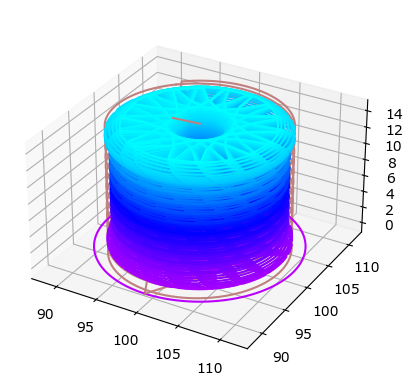

In [8]:
# add annotations and plot
EW=1.0
EH=0.2
fc.transform(wiresteps+steps, 'plot', fc.PlotControls(style='line',color_type='print_sequence', initialization_data={'extrusion_width': EW, 'extrusion_height': EH}))

In [ ]:
#design parameters

design_name = 'capstan'
nozzle_temp = 220
bed_temp = 120
print_speed = 10*60
fan_percent = 0
EH = 0.2    # extrusion heigth
EW = 0.5    # extrusion width
printer_name = 'generic'
#printer_name = 'Prusa_Mendel'
gcode_controls = fc.GcodeControls(
    printer_name=printer_name,
    save_as=design_name,
    initialization_data={
        'primer': 'no_primer',
        'print_speed': print_speed,
        'nozzle_temp': nozzle_temp,
        'bed_temp': bed_temp,
        'fan_speed':fan_percent,
         })
gcode = fc.transform(steps, 'gcode', gcode_controls)

In [ ]:
pr1_r